In [1]:
import VAE
from VAE import CVAE, CoCVAE
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)

mps


In [378]:
def plot_latent_space(model, scale=7.0, n=25, digit_size=28, figsize=12):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi, 0, 0, 0, 0, 0, 0 ,0 ,0 ]], dtype=torch.float, device=device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit.cpu() > 0.5

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z0")
    plt.ylabel("z1")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

def plot_latent_space_cond(model, num, scale=7.0, n=25, digit_size=28, figsize=12):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float, device=device)
            x_decoded = model.decode(z_sample, torch.eye(10)[num].view(1,10).to(device))
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit.cpu() > 0.5

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z0")
    plt.ylabel("z1")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

In [369]:
data2 = pd.read_csv('archive/fashion-mnist_test.csv')
Y = torch.tensor(data2['label'].to_numpy(), device='cpu') 
Xc = torch.eye(10)[Y].to(device)
Xn_mnist =  torch.tensor(data2.drop('label', axis = 1).to_numpy(), device=device) / 255

gen = torch.Generator(device=device)
gen.manual_seed(123)

In [4]:
vae = CVAE(2, gen=gen, device=device)
vae2 = CVAE(2, gen=gen, device=device)
vae3 = CoCVAE(2, gen=gen, device=device)
vae4 = CoCVAE(2, gen=gen, device=device)

vae.load_state_dict(torch.load('saved_models/vae_B1_CF_Z2_FF'))
vae2.load_state_dict(torch.load('saved_models/vae_B25_CF_Z2_FF'))
vae3.load_state_dict(torch.load('saved_models/vae_B1_CT_Z2_FF'))
vae4.load_state_dict(torch.load('saved_models/vae_B25_CT_Z2_FF'))

vae.to(device).eval()
vae2.to(device).eval()
vae3.to(device).eval()
vae4.to(device).eval()

CoCVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.1, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (z_mean): Linear(in_features=1024, out_features=2, bias=True)
  (z_log_var): Linear(in_features=1024, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=1024, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(16, 8, 8))
    (2): ConvTranspose2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): Upsample(scale_factor=2.0, mode='bilinear')
    (4): Dropout(p=0.1, inplace=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
  )
)

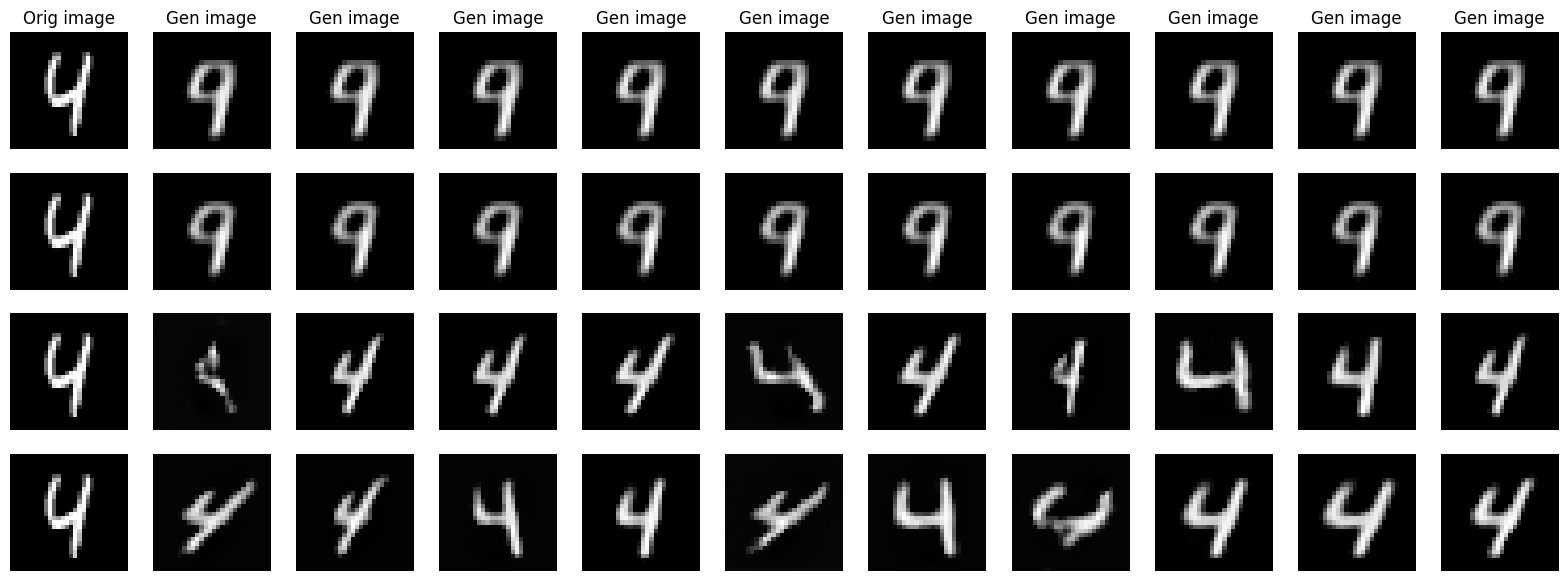

In [5]:
id = torch.randint(0, len(Xn_mnist),(1,1))

fig, axes = plt.subplots(4,11, figsize=(20,7) )

axes[0,0].imshow(Xn_mnist[id].view(28,28).cpu(), cmap='gray')
axes[0,0].axis('off')
axes[0,0].set_title('Orig image')

axes[1,0].imshow(Xn_mnist[id].view(28,28).cpu(), cmap='gray')
axes[1,0].axis('off')

axes[2,0].imshow(Xn_mnist[id].view(28,28).cpu(), cmap='gray')
axes[2,0].axis('off')

axes[3,0].imshow(Xn_mnist[id].view(28,28).cpu(), cmap='gray')
axes[3,0].axis('off')

for i in range(1,11):
    axes[0,i].imshow(vae.reproduce(Xn_mnist[id].view(1,1,28,28)).cpu().view(28,28), cmap='gray')
    axes[0,i].set_title('Gen image')
    axes[0,i].axis('off')

for i in range(1,11):
    axes[1,i].imshow(vae2.reproduce(Xn_mnist[id].view(1,1,28,28)).cpu().view(28,28), cmap='gray')
    axes[1,i].axis('off')
    
for i in range(1,11):
    axes[2,i].imshow(vae3.generate(Xc[id].view(1,10)).cpu().view(28,28), cmap='gray')
    axes[2,i].axis('off')
    
for i in range(1,11):
    axes[3,i].imshow(vae4.generate(Xc[id].view(1,10)).cpu().view(28,28), cmap='gray')
    axes[3,i].axis('off')
 
plt.axis('off')
plt.show()


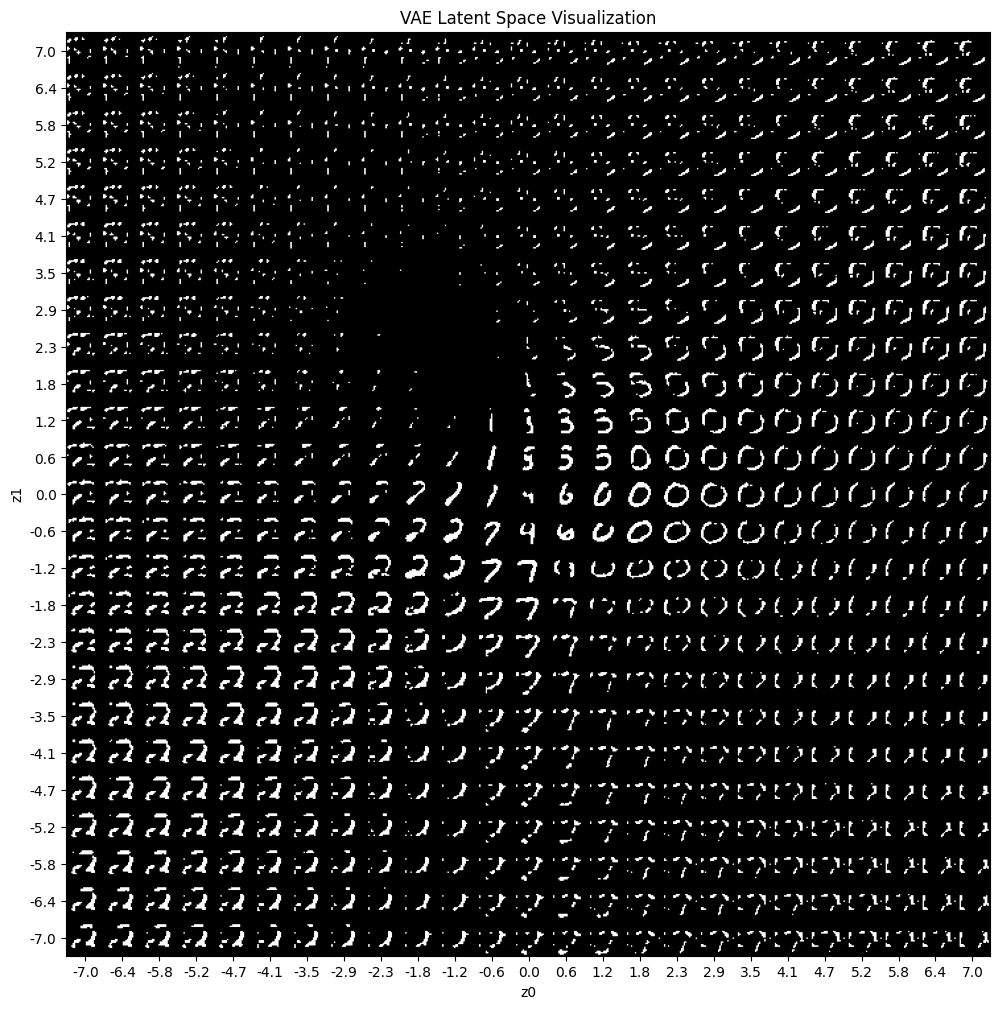

In [6]:
plot_latent_space(vae)

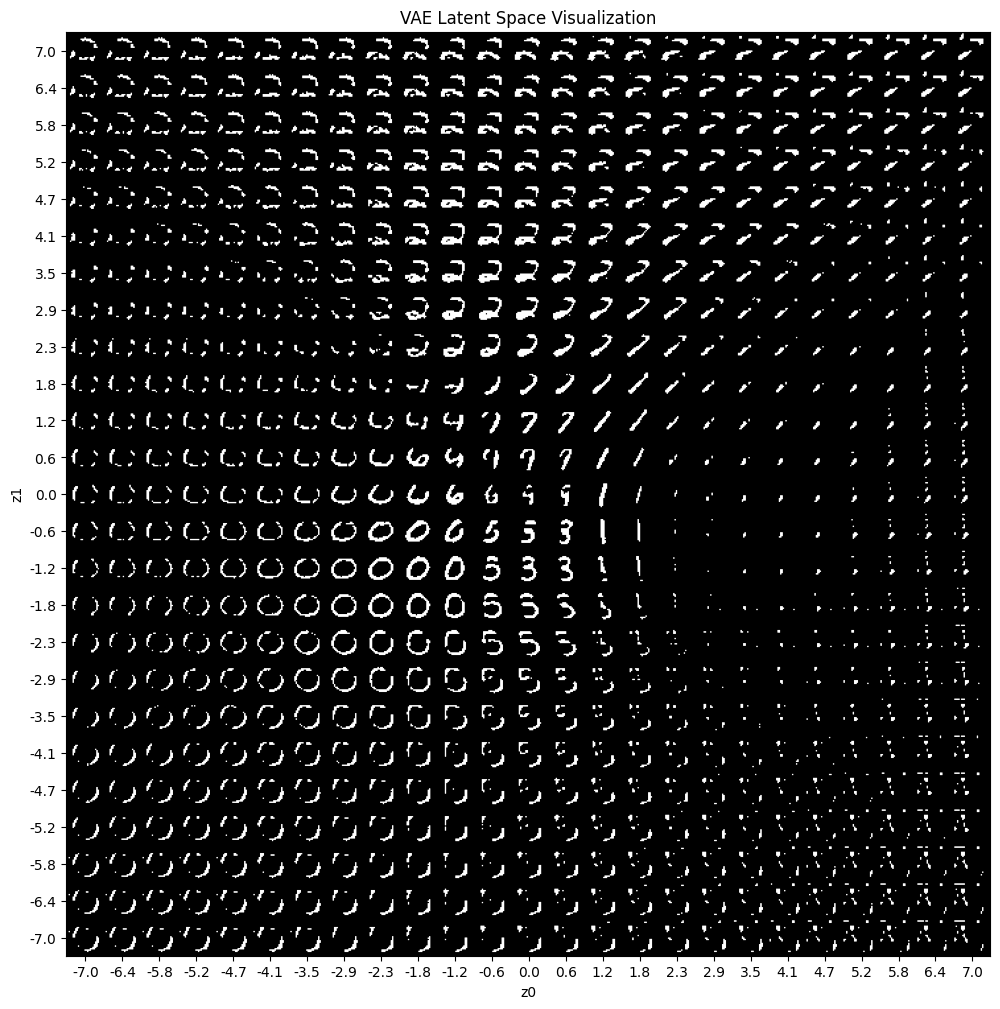

In [7]:
plot_latent_space(vae2)

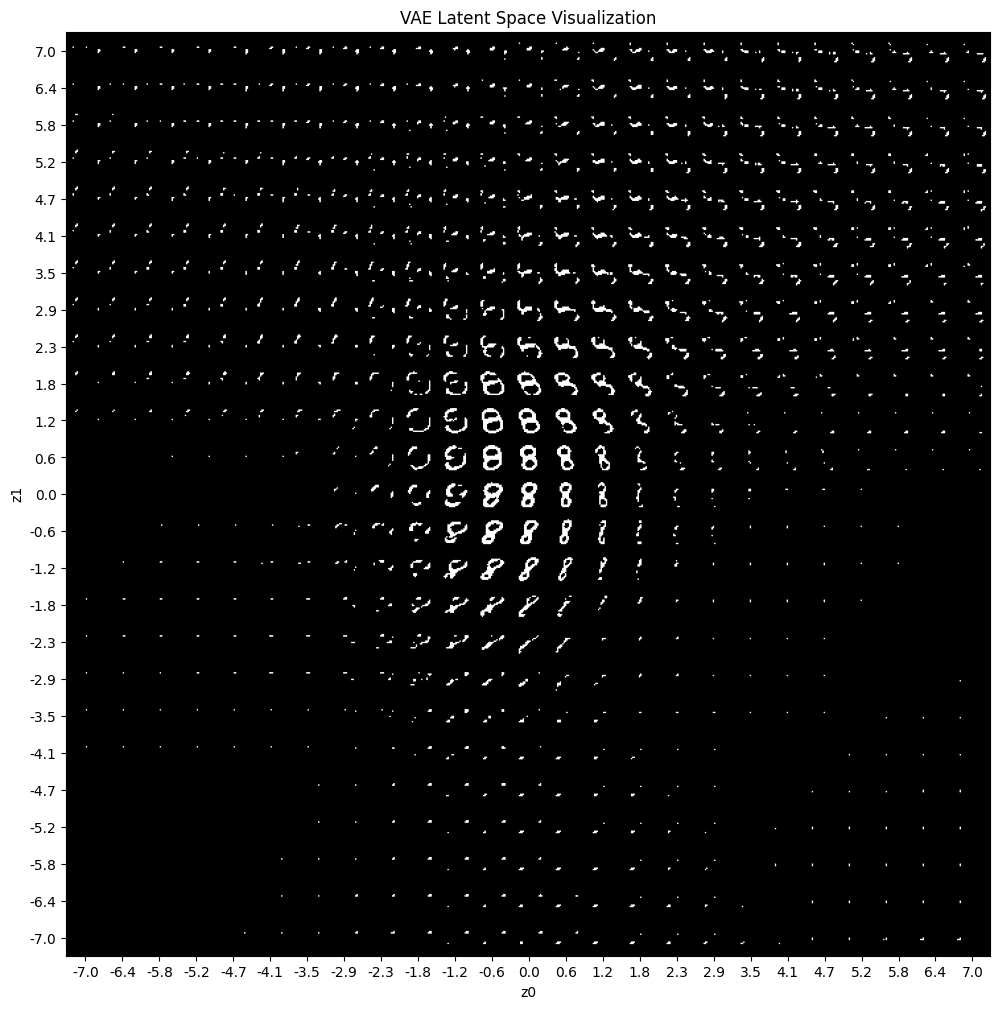

In [8]:
plot_latent_space_cond(vae3, 8)

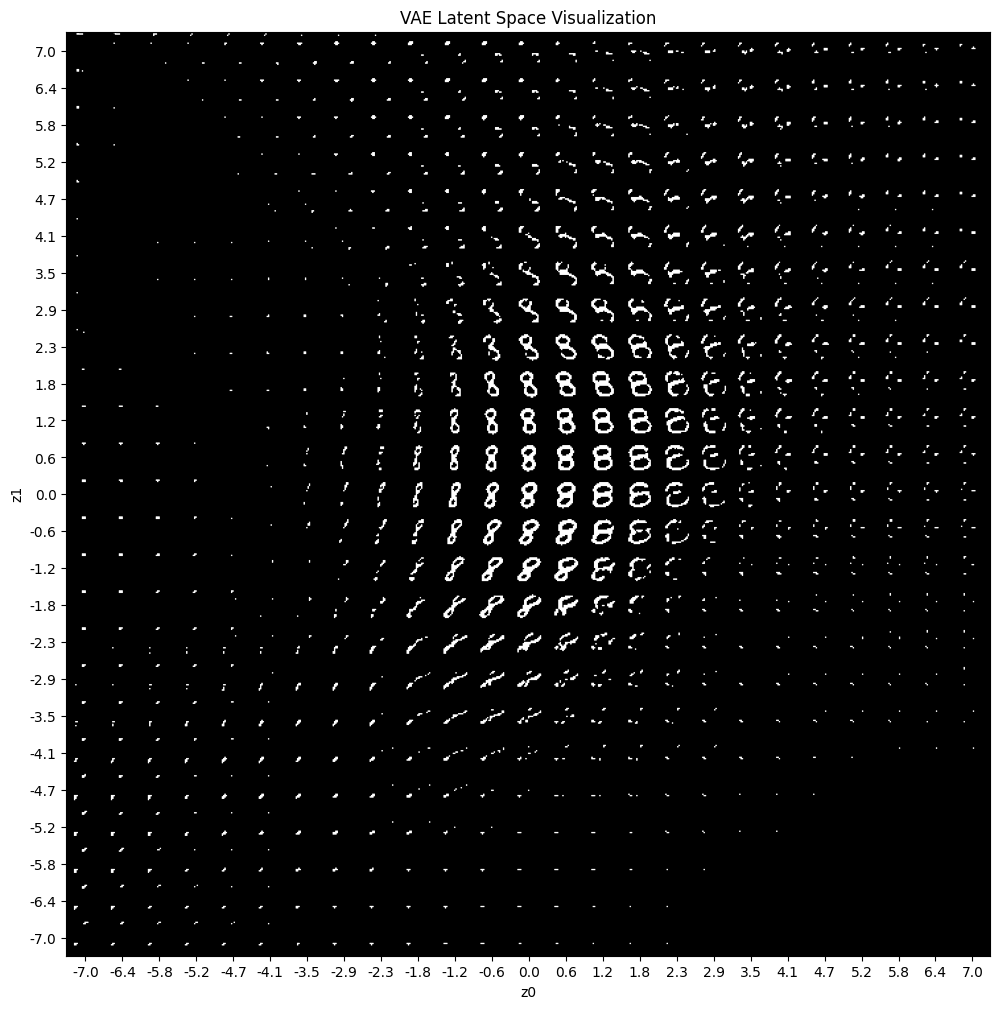

In [9]:
plot_latent_space_cond(vae4, 8)

In [558]:
vae0 = CVAE(10, gen=gen, device=device)
vae10 = CVAE(10, gen=gen, device=device)
vae1000 = CVAE(10, gen=gen, device=device)

vae0.load_state_dict(torch.load('saved_models/vae_B1_CF_Z10_FT'))
vae10.load_state_dict(torch.load('saved_models/vae_B250_CF_Z10_FT'))
vae1000.load_state_dict(torch.load('saved_models/vae_B1000_CF_Z10_FT'))

vae0.to(device).eval()
vae10.to(device).eval()
vae1000.to(device).eval()

CVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.1, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (z_mean): Linear(in_features=1024, out_features=10, bias=True)
  (z_log_var): Linear(in_features=1024, out_features=10, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1024, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(16, 8, 8))
    (2): ConvTranspose2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): Upsample(scale_factor=2.0, mode='bilinear')
    (4): Dropout(p=0.1, inplace=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
  )
)

In [596]:
def plot_latent_axis(model, scale=7.0, n=25, digit_size=28, figsize=15):
    latent_dim = model.lat
    figure = np.zeros((latent_dim*digit_size, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    
    for i in range(latent_dim):
       for j, xi in enumerate(grid_x):
                z_sample = torch.tensor([[ (i == 0)*xi, (i == 1)*xi, (i == 2)*xi, (i == 3)*xi, (i == 4)*xi,
                                          ( i == 5)*xi, (i == 6)*xi, (i == 7)*xi, (i == 8)*xi, (i == 9)*xi,
                                          #(i == 10)*xi, (i == 11)*xi, (i == 12)*xi, (i == 13)*xi, (i == 14)*xi,( i == 15)*xi, (i == 16)*xi, (i == 17)*xi, (i == 18)*xi, (i == 19)*xi]],
                                            ]],dtype=torch.float, device=device)
                x_decoded = model.decode(z_sample)
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit.cpu()
    
    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range_x = np.arange(start_range, end_range, digit_size)
    pixel_range_y = np.arange(start_range, latent_dim* digit_size + start_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = range(latent_dim)
    plt.xticks(pixel_range_x, sample_range_x)
    plt.yticks(pixel_range_y, sample_range_y)
    plt.xlabel("z value sampled")
    plt.ylabel("Latent dimension")
    plt.imshow(figure, cmap="gray")
    plt.show()       

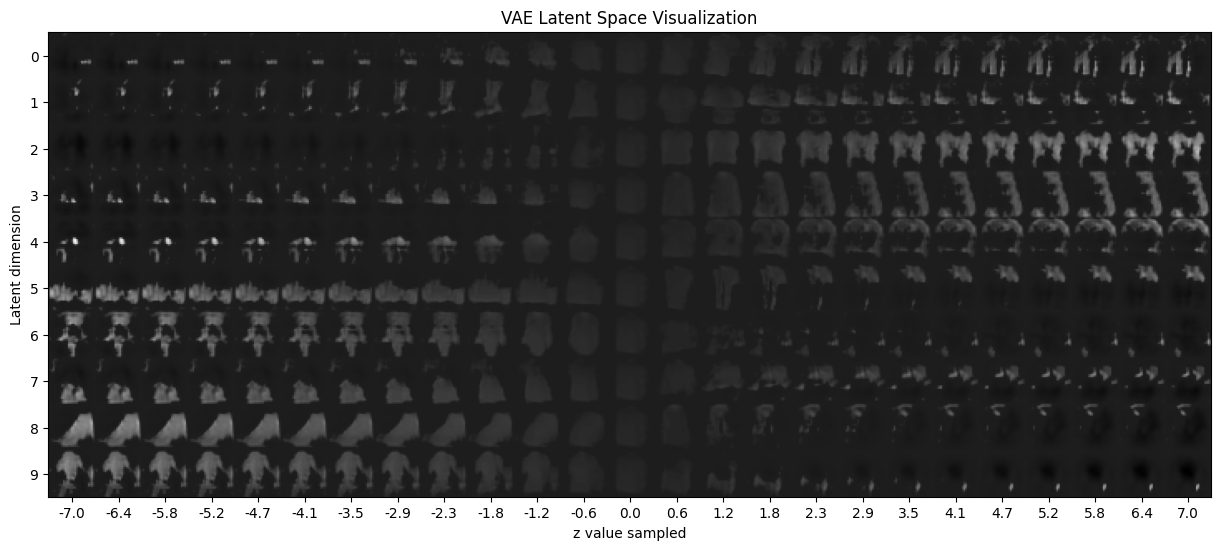

In [597]:
plot_latent_axis(vae0)

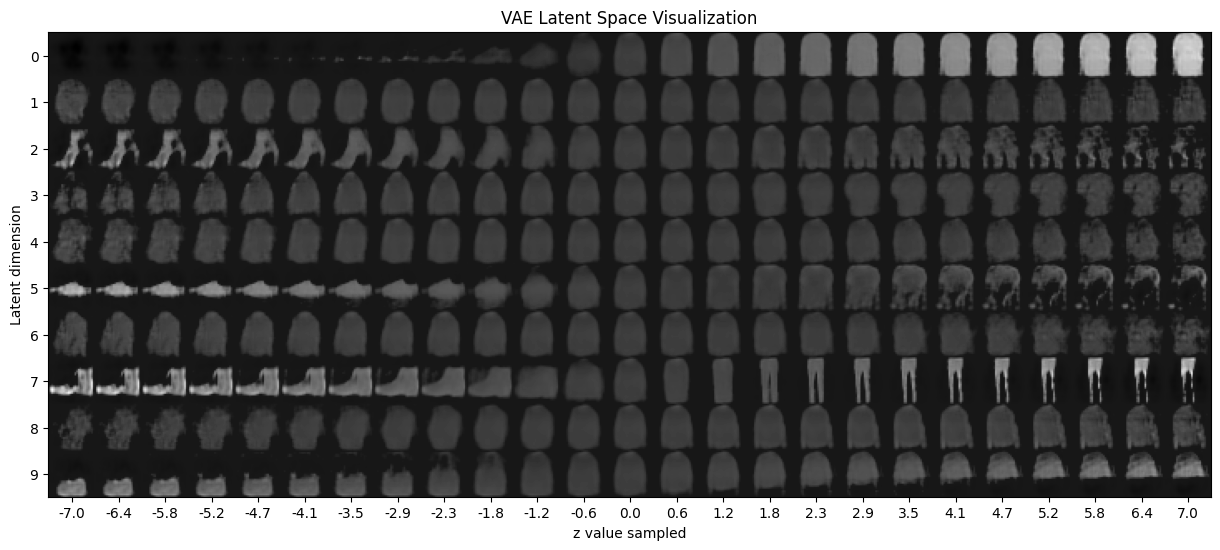

In [598]:
plot_latent_axis(vae10)

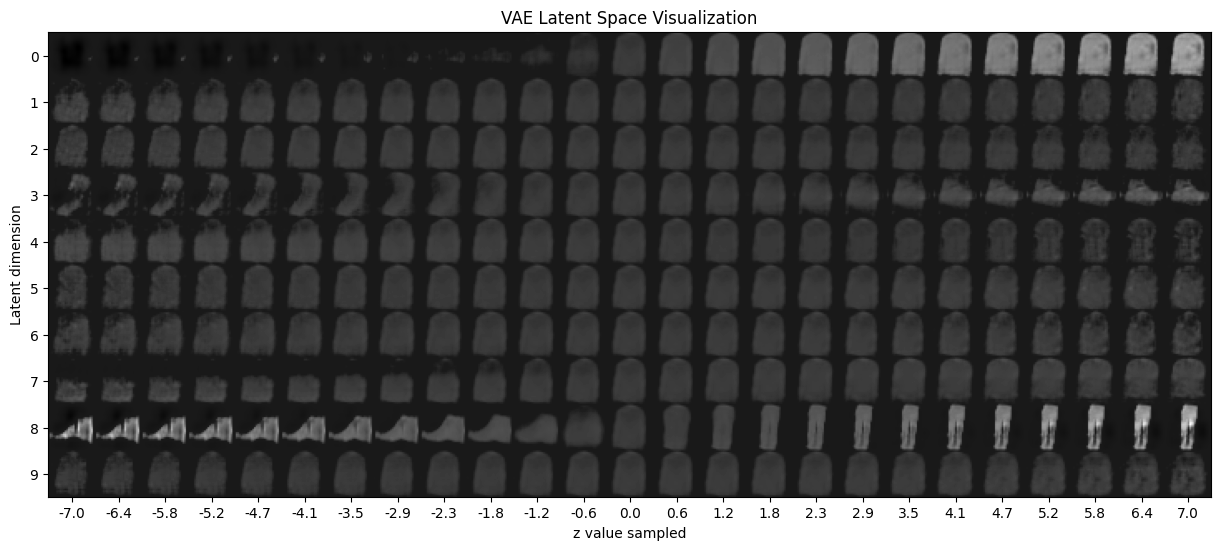

In [599]:
plot_latent_axis(vae1000)

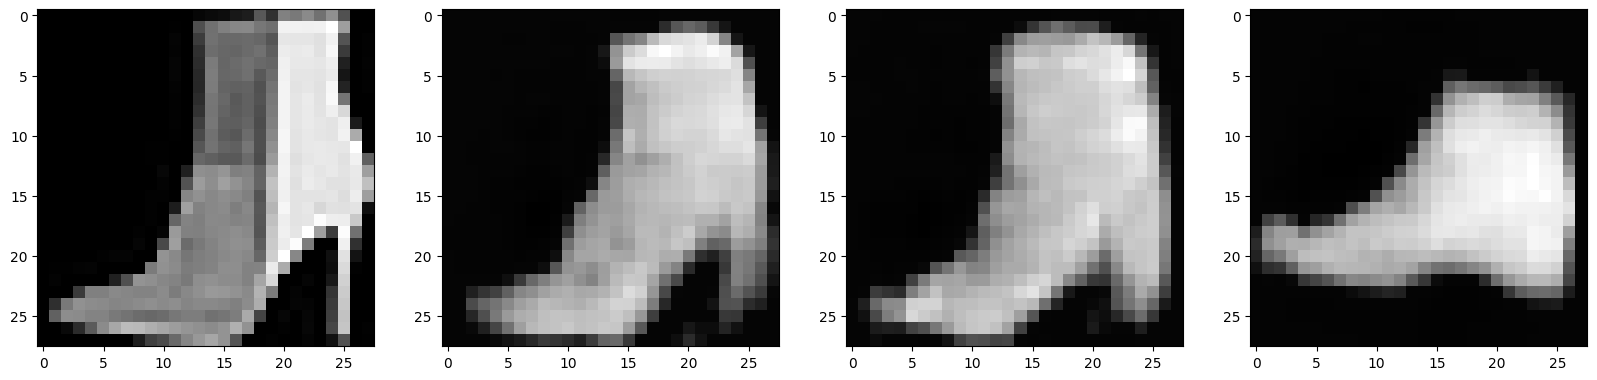

In [563]:
fig, ax = plt.subplots(1,4, figsize=(20,10))

id = torch.randint(0, len(Xn_mnist),(1,))

ax[0].imshow(Xn_mnist[id].view(28,28).cpu(), cmap='gray')
ax[1].imshow(vae0.reproduce(Xn_mnist[id].view(1,1,28,28)).cpu().view(28,28), cmap='gray')
ax[2].imshow(vae10.reproduce(Xn_mnist[id].view(1,1,28,28)).cpu().view(28,28), cmap='gray')
ax[3].imshow(vae1000.reproduce(Xn_mnist[id].view(1,1,28,28)).cpu().view(28,28), cmap='gray')

plt.show()

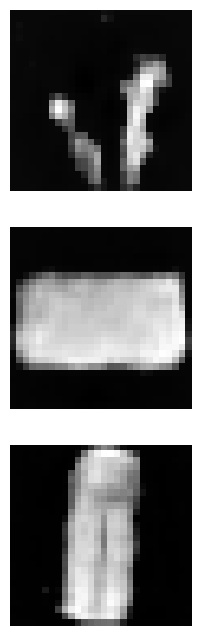

In [589]:
fig, ax = plt.subplots(3,1, figsize=(10,8))

id = torch.randint(0, len(Xn_mnist),(1,))

ax[0].imshow(vae0.generate().cpu().view(28,28), cmap='gray')
ax[0].axis('off')

ax[1].imshow(vae10.generate().cpu().view(28,28), cmap='gray')
ax[1].axis('off')

ax[2].imshow(vae1000.generate().cpu().view(28,28), cmap='gray')
ax[2].axis('off')

plt.show()